<a href="https://colab.research.google.com/github/rodrigamoris-hash/proyecto_cultivo/blob/main/Proyecto_cultivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vista inicial del dataset:
   ph_suelo  humedad (%) tipo_suelo  temperatura (°C)  precipitacion (mm)  \
0      5.48         67.2  arcilloso              19.0               129.1   
1      8.45         50.5    arenoso              33.1               202.2   
2      7.64         56.0    arenoso              15.7               293.8   
3      8.15         77.6     limoso              15.9               146.5   
4      6.28         86.2    arenoso              23.2               151.8   

   horas_sol (h/día) tipo_de_cultivo  altitud (m)  densidad_suelo (g/cm3)  \
0                8.5            maíz          137                    1.22   
1                9.4          cebada          176                    1.22   
2                9.3           arroz         2385                    1.49   
3               10.1            soja         1335                    1.47   
4               10.6           trigo         1627                    1.28   

   nivel_nutrientes (mg/kg)  velocidad_viento (

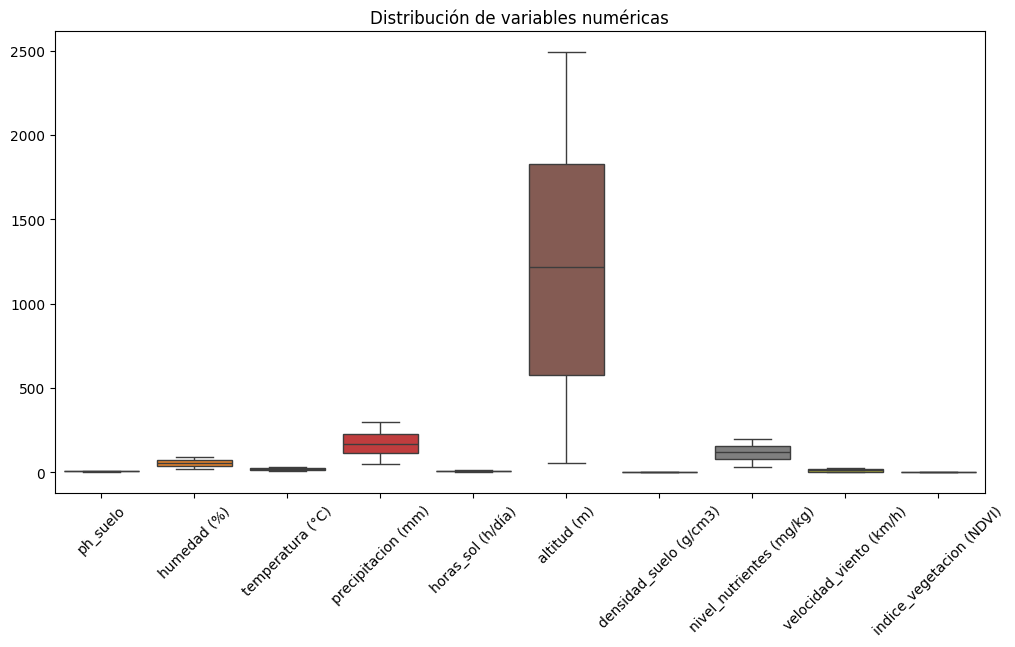

/tmp/ipython-input-2872051202.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='tipo_de_cultivo', palette="viridis")


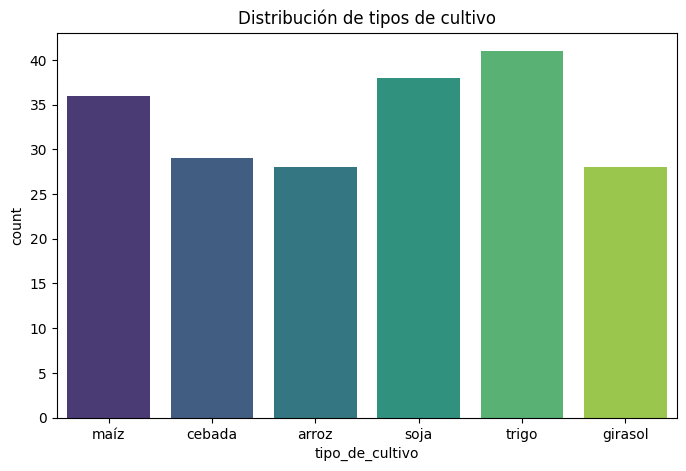

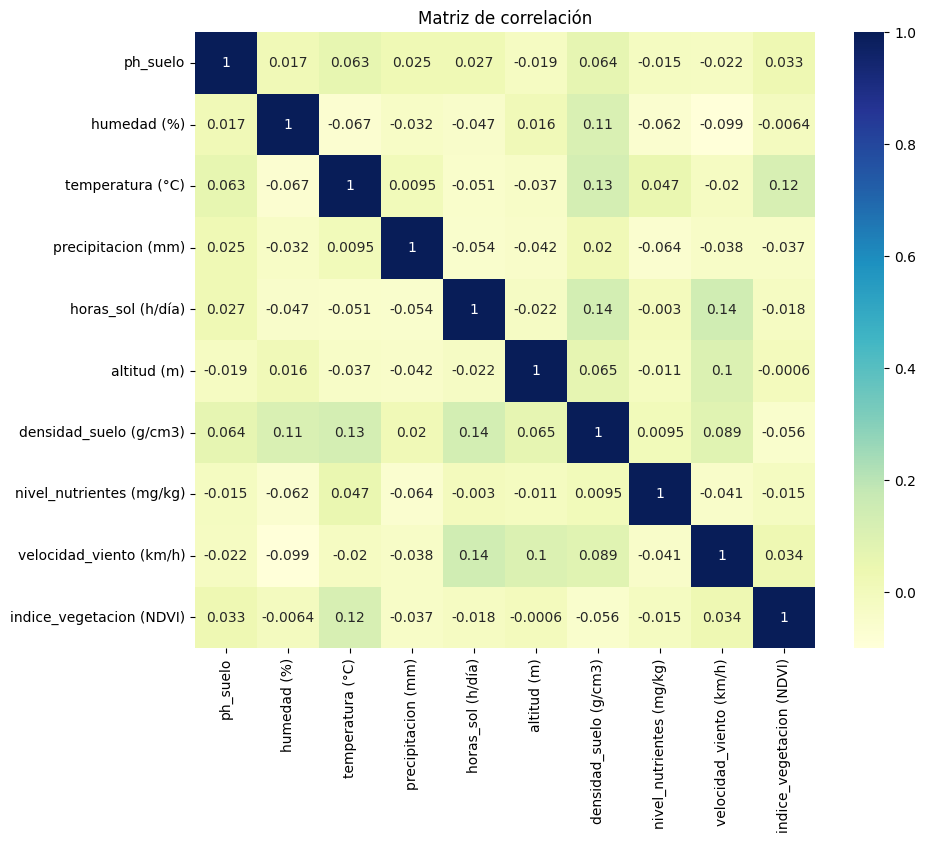


Resultados - Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.20      0.14      0.17         7
           2       0.40      0.29      0.33         7
           3       0.17      0.33      0.22         9
           4       0.25      0.20      0.22        10
           5       0.09      0.10      0.10        10

    accuracy                           0.18        50
   macro avg       0.18      0.18      0.17        50
weighted avg       0.18      0.18      0.17        50


Resultados - XGBoost:
              precision    recall  f1-score   support

           0       0.12      0.14      0.13         7
           1       0.33      0.14      0.20         7
           2       0.25      0.29      0.27         7
           3       0.19      0.33      0.24         9
           4       0.33      0.20      0.25        10
           5       0.33      0.30      0.32        10

    accuracy             

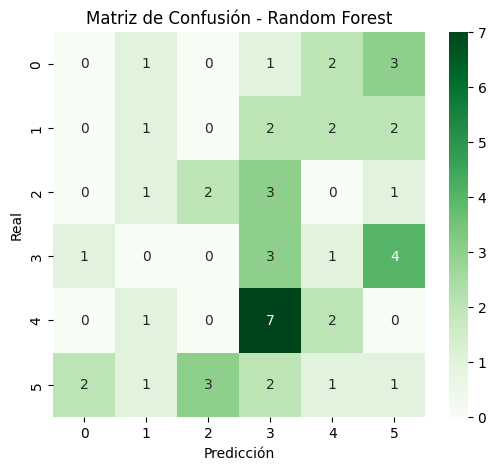

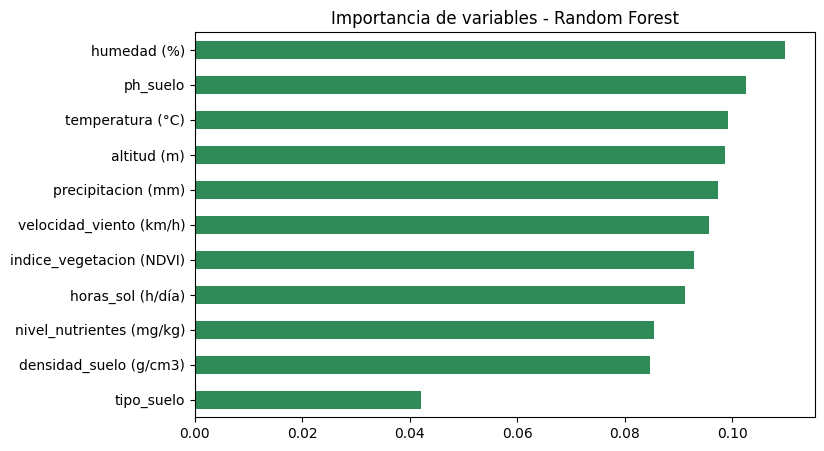


Predicción de ejemplo (según condiciones dadas): trigo


In [ ]:
#1. Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

#2. Cargar el dataset enriquecido

df = pd.read_excel("dataset_cultivos_enriquecido_final.xlsx")
print("Vista inicial del dataset:")
print(df.head())

#3. Información general

print("\nInformación general del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

#4. Visualización de distribuciones

plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include=np.number))
plt.title("Distribución de variables numéricas")
plt.xticks(rotation=45)
plt.show()

#Distribución por tipo de cultivo

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='tipo_de_cultivo', palette="viridis")
plt.title("Distribución de tipos de cultivo")
plt.show()

#5. Correlación

plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="YlGnBu")
plt.title("Matriz de correlación")
plt.show()

#6. Preprocesamiento

df_encoded = df.copy()

#Codificar variables categóricas

label_encoders = {}
for col in ['tipo_suelo', 'tipo_de_cultivo']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

#Separar variables predictoras y objetivo

X = df_encoded.drop(columns=['tipo_de_cultivo'])
y = df_encoded['tipo_de_cultivo']

#Normalizar variables numéricas

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#7. División de datos

X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

#8. Entrenamiento de modelos
#--- Modelo 1: Random Forest ---

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nResultados - Random Forest:")
print(classification_report(y_test, y_pred_rf))

#--- Modelo 2: XGBoost ---

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test) # Corrected: predict on X_test

print("\nResultados - XGBoost:")
print(classification_report(y_test, y_pred_xgb))

#9. Matriz de confusión (Random Forest)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#10. Importancia de características

importances = pd.Series(rf.feature_importances_, index=df_encoded.drop(columns=['tipo_de_cultivo']).columns)
importances.sort_values().plot(kind='barh', figsize=(8, 5), color='seagreen')
plt.title("Importancia de variables - Random Forest")
plt.show()

#11. Predicción de ejemplo con nuevas variables

ejemplo = pd.DataFrame({
'ph_suelo': [6.8],
'humedad (%)': [65],
'tipo_suelo': [label_encoders['tipo_suelo'].transform(['franco'])[0]],
'temperatura (°C)': [27],
'precipitacion (mm)': [140],
'horas_sol (h/día)': [9],
'altitud (m)': [800],
'densidad_suelo (g/cm3)': [1.3],
'nivel_nutrientes (mg/kg)': [120],
'velocidad_viento (km/h)': [10],
'indice_vegetacion (NDVI)': [0.7]
})

#Escalar ejemplo y predecir

ejemplo_scaled = scaler.transform(ejemplo)
prediccion = xgb.predict(ejemplo_scaled)
cultivo_predicho = label_encoders['tipo_de_cultivo'].inverse_transform(prediccion)
print(f"\nPredicción de ejemplo (según condiciones dadas): {cultivo_predicho[0]}")

Aquí se muestra la distribución de las variables numéricas a través de diagramas de caja. Esto ayuda a identificar la mediana, los cuartiles y los posibles valores atípicos en cada variable.

Este gráfico de barras muestra el número de instancias para cada tipo de cultivo en el dataset, permitiendo visualizar el desbalance de clases si lo hay.

La matriz de correlación muestra la relación entre las variables numéricas. Los valores cercanos a 1 o -1 indican una fuerte correlación positiva o negativa, respectivamente, mientras que los valores cercanos a 0 indican poca correlación.

La matriz de confusión para el modelo Random Forest muestra el número de predicciones correctas e incorrectas para cada clase, lo que permite evaluar el rendimiento del modelo en detalle.

Este gráfico de barras horizontales muestra la importancia relativa de cada variable en la predicción del tipo de cultivo según el modelo Random Forest. Las variables con barras más largas tienen un mayor impacto en la predicción.